[FINM 33150] Regression Analysis and Quantitative Trading Strategies\
Winter 2022 | Professor Brian Boonstra

# HW #5 FX Carry Strategy

_**Due:** Thursday, February 17th, at 11:00pm\
**Name:** Ashley Tsoi (atsoi, Student ID: 12286230)_

### 1. Function definitions

#### 1-1. Import packages

In [1]:
import os
from pathlib import Path
import functools
# from tqdm.notebook import tqdm_notebook as tqdm
import warnings

import quandl
import json
import pandas as pd
pd.set_option("display.precision", 4)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# import math
import numpy as np
import statsmodels.api as sm
import datetime as dt

# let plot display in the notebook instead of in a different window
%matplotlib inline 
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [21, 8]
import seaborn as sns

#### 1-2. Functions to fetch data

**1-2-1. Get my personal keys** from ../data/APIs.json

In [2]:
f = open('../data/APIs.json')
APIs = json.load(f)
f.close()

**1-2-2. Define helper functions**

In [3]:
def assertCorrectDateFormat(date_text):
    try:
        dt.datetime.strptime(date_text, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Incorrect date format, should be YYYY-MM-DD")


def periodToYearFloat(periodString):
    # Converts period strings (e.g. 1-Month, 5-Month, 1-Year) 
    # to year float (1-Month=0.08, 5-Month=0.4, 1-Year=1)
    # NOTE: The number of digits follow the rule of np.round(), decimal=2
    # Use to change column names

    n,period = periodString.split('-')
    n = int(n)
    
    if period=='Week':
        weekToYr = 0.02
        n*=weekToYr
    elif period=='Month':
        monthToYr = 0.08
        n*=monthToYr
    elif period!='Year':
        raise ValueError('periodString must end with Month or Year.')
    
    return np.round(n,2)

# Unit tests for periodToYearFloat
assert periodToYearFloat('1-Year')==1.0
assert periodToYearFloat('5-Year')==5.0
assert periodToYearFloat('1-Month')==0.08
assert periodToYearFloat('5-Month')==0.4
assert periodToYearFloat('1-Week')==0.02


def yearFloatToPeriod(yearFloat):
    # Converts year float (1-Month=0.08, 5-Month=0.4, 1-Year=1)
    # to period strings (e.g. 1-Month, 5-Month, 1-Year) 
    # Use to change column names

    if yearFloat<0.08:
        period = 'Week'
        yearToWeek = 0.02
        n = round(yearFloat/yearToWeek,2)
    elif yearFloat<1:
        period = 'Month'
        yearToMonth = 0.08
        n = round(yearFloat/yearToMonth,2)
    elif yearFloat==int(yearFloat):
        period = 'Year'
        n = yearFloat
    else:
        raise ValueError('yearFloat must be an integer if greater than 1.')

    # Remove trailing .0 for ints
    n_int = int(n)
    if n==n_int: n = n_int

    return str(n)+'-'+period

# Unit tests for yearFloatToPeriod
assert yearFloatToPeriod(1)=='1-Year'
assert yearFloatToPeriod(1.0)=='1-Year'
assert yearFloatToPeriod(5)=='5-Year'
assert yearFloatToPeriod(0.08)=='1-Month'
assert yearFloatToPeriod(0.4)=='5-Month'
assert yearFloatToPeriod(0.02)=='1-Week'

**1-2-3. Define function** to retrieve raw data from Quandl

**Define `get1mOIS` to retrieve 1M UK overnight index swaps (OIS) and `getSpotUSD` to get spot rates for dollar versus currency** from Quandl's `Global Yield Curves (YC)` database. 

**Documentation:**
```
Global Yield Curves (YC)
https://data.nasdaq.com/data/YC-global-yield-curves/documentation
```

In [4]:
@functools.lru_cache(maxsize=16) # Cache the function output
def getQuandlYCData(yc,start_date,end_date):
    # Get one security (sec)'s data fom Quandl using quandl.get_table
    # NOTE: missing data for the inputted date will NOT return a row.

    # INPUT         | DATA TYPE                 | DESCRIPTION
    # yc            | string / list of string   | yield curve security code
    # start_date    | string (YYYY-MM-DD)       | start date of data
    # end_date      | string (YYYY-MM-DD)       | end date of data (same as or after start_date)
    
    assertCorrectDateFormat(start_date)
    assertCorrectDateFormat(end_date)
    
    # Retrieve data using quandl.get_table
    quandl.ApiConfig.api_key = APIs['Quandl']
    data = quandl.get('YC/'+yc,
                      start_date=start_date, 
                      end_date=end_date
                      )

    print(f"Quandl | YC    | Returning {len(data):d} dates of data for {yc}.")
    return data

def get1mOIS(yc,start_date='2009-01-01',end_date='2022-01-31'):
    ois_1m = getQuandlYCData(yc,start_date,end_date)[['0.08Y']].rename(columns={'0.08Y':'OIS_1M'})
    return ois_1m

def getSpotUSD(cur,start_date='2009-01-01',end_date='2022-01-31'):
    return getQuandlYCData(cur,start_date,end_date)

**Define `getQuandlCURData` to retrieve spot rates data** from Quandl's `Foreign Exchange Rates (CUR)` database. 

**Scope:** 
- Currency codes: ZAR, THB, PKR, and PHP
- Dates: 2009-01-01 -- 2022-01-31

**Documentation:**
```
Foreign Exchange Rates (CUR)
https://data.nasdaq.com/data/CUR-foreign-exchange-rates/documentation
```

In [5]:
@functools.lru_cache(maxsize=16) # Cache the function output
def getQuandlCURData(cur,start_date,end_date):
    # Get one security (sec)'s data fom Quandl using quandl.get_table
    # NOTE: missing data for the inputted date will NOT return a row.

    # INPUT         | DATA TYPE                 | DESCRIPTION
    # cur           | string                    | currency code
    # start_date    | string (YYYY-MM-DD)       | start date of data
    # end_date      | string (YYYY-MM-DD)       | end date of data (same as or after start_date)
    # columns       | string / list of string   | columns to return
    
    assertCorrectDateFormat(start_date)
    assertCorrectDateFormat(end_date)
    
    # Retrieve data using quandl.get_table
    quandl.ApiConfig.api_key = APIs['Quandl']
    data = quandl.get('CUR/'+cur,
                      start_date=start_date, 
                      end_date=end_date
                      )

    print(f"Quandl | CUR   | Returning {len(data):d} dates of data for {cur}.")
    return data

def getSpotFX(cur,start_date='2009-01-01',end_date='2022-01-31'):
    data = getQuandlCURData(cur,start_date,end_date)
    data.index.name = 'Date'
    return data

#### 1-3. Functions to clean and calculate data

**1-3-1. Define function to interpolate rates from sparse data**

In [6]:
def interpolateRates(rates_df,tenor_max=None,step=0.02):
    # Linearly interpolate rates
    # NOTE: Returned dataframe has number of columns equal to len(np.arange(0, tenor_max, step))-1
    # NOTE: time & step are in unit of years (0.02 year ~ 1 week)
    
    # INPUT         | DATA TYPE                 | DESCRIPTION
    # rates_df      | DataFrame                 | columns: tenors (e.g. "1-Month", "2-Year"), index: Date
    # tenor_max     | int / float / None        | the resulting columns' last column
    # step          | int / float               | the tenor gap between the resulting df's columns

    if step<=0: raise ValueError('step must be greater than 0.')

    tenor_sparse = [periodToYearFloat(t) for t in rates_df.columns]
    
    if not tenor_max:
        tenor_max = max(tenor_sparse)

    tenor_range = np.around(np.arange(tenor_max, 0, step=-step)[::-1],2)
    rates = pd.DataFrame(columns=tenor_range, index=rates_df.index)

    for t,rates_val in rates_df.iterrows():
        # linearly interpolate the rates for tenor_range according to each col from rates_df
        rates.loc[t] = np.interp(tenor_range, tenor_sparse, rates_val.values)
    
    return rates

**1-3-2. Defind function to calculate zero coupon bond (ZCB) rates**

In [7]:
def calcZCB(original_rt_df,tenor=5):
    # Calculate zero coupon bond (ZCB) prices by interpolating spot rates with 
    # the time to maturity (ttm), using spot_df's time index and each column's rates
    
    zcb = pd.DataFrame(columns=original_rt_df.columns)
    dates = original_rt_df.index

    for ttm,rates in original_rt_df.items():
        tenor = periodToYearFloat(ttm)

        # Interpolate rates
        rates_interpolated = interpolateRates(pd.DataFrame(rates),tenor,step=0.02)
        
        rts = (rates_interpolated.columns*rates_interpolated).astype('float')

        # Calculate half year rates
        rt_halfYr = 1+(rates*0.5).astype('float')
        maturity_val = (np.exp(rts).multiply(rt_halfYr,axis='index')).sum()/100
        
        # Calculate time 0 ZCB price for the tenor
        zcb[ttm] = pd.Series(np.log(abs((1-maturity_val[tenor])/rt_halfYr)) / tenor, index=dates)

    return zcb

#### 1-4. Functions for trade simulation

**1-4-1. Define function to simulate a carry trade**

In [19]:
def simCarryTrade(lend_cur,fx_lend_cur,borrow_cur='GBR',fx_borrow_cur='GBP',tenor_lend=5,dataIsZCB=False):
    
    # ==================================================
    # === GET DATA =====================================
    # NOTE: resample non-FX data to weekly (use Wednesday)
    # NOTE: keep track of "max start date" & "min end date" for later
    yc_lend_week = getSpotUSD(lend_cur).resample('W-WED').ffill()
    yc_lend_week = yc_lend_week[[col for col in yc_lend_week.columns if 'to' not in col]]

    start_date,end_date = yc_lend_week.index.min(),yc_lend_week.index.max()
    
    tenor_period = yearFloatToPeriod(tenor_lend)
    yc_borrow_week = getSpotUSD(borrow_cur)[tenor_period].resample('W-WED').ffill()
    start_date,end_date = max(start_date,yc_borrow_week.index.min()),min(end_date,yc_borrow_week.index.max())
    
    fx_lend = getSpotFX(fx_lend_cur).RATE
    start_date,end_date = max(start_date,fx_lend.index.min()),min(end_date,fx_lend.index.max())
    
    fx_borrow = getSpotFX(fx_borrow_cur).RATE
    start_date,end_date = max(start_date,fx_borrow.index.min()),min(end_date,fx_borrow.index.max())
    
    print("Trade  | data  | Retrieved all rates data from Quandl.")

    # ==================================================
    # === CLEAN / JOIN DATA ============================
    # 1. Make the date range of all tables above consistent
    # NOTE: use the "max start date" & "min end date" from above
    # 2. Merge all data into 1 dataframe named zcb_week

    yc_lend_week = yc_lend_week.loc[start_date:end_date]

    # Makes sure yield curve for the lending currency is ZCB
    if dataIsZCB:
        zcb_week = yc_lend_week
    else: # convert to ZCB
        zcb_week = calcZCB(yc_lend_week)

    # Interpolate data for missing periods
    zcb_week = interpolateRates(zcb_week,tenor_max=tenor_lend)[[tenor_lend]]
    
    borrow_rt_name = borrow_cur+'_'+str(tenor_lend)+'y'
    zcb_week[borrow_rt_name] = yc_borrow_week[start_date:end_date] # this is a Series
    
    fx_lend = fx_lend[start_date:end_date] # this is a Series (no need .loc)
    fx_lend.name = 'USD'+fx_lend_cur
    zcb_week = zcb_week.merge(fx_lend, how='left', on='Date')
    
    fx_borrow = fx_borrow[start_date:end_date] # this is a Series (no need .loc)
    fx_borrow.name = 'USD'+fx_borrow_cur
    zcb_week = zcb_week.merge(fx_borrow, how='left', on='Date')
    
    fx = fx_borrow/fx_lend
    fx.name = fx_borrow_cur+fx_lend_cur
    zcb_week = zcb_week.merge(fx, how='left', on='Date')

    print(f"Trade  | data  | Data has date range from {start_date} to {end_date}.")
    
    # ==================================================
    # === TRADE ========================================
    # Get trade positions

    zcb_week['position'] = (zcb_week[tenor_lend] > zcb_week[borrow_rt_name]+0.5).astype(int)
    
    return zcb_week

**1-4-2. Define functions to calculate trade performance**

In [9]:
def calcTradeStats(table,price_col_name,leverage=5,r=0,init_cash=10000000):
    # table must contain columns (1) price*volumn (2) position
    # returns columns: [table.columns] + [signal, position_value, cash, total_value, PnL_daily, PnL_cumulative]

    # notional_frac = 1-(1/leverage)

    table['signal'] = [table.position[0]] + table.position.diff()[1:].astype(np.int16).tolist()
    table['position_value'] = table[price_col_name] * table.position
    table['cash'] = np.cumsum([init_cash-table.position_value[0]] + (-1*(table.signal*table[price_col_name])[1:]).tolist())
    table['interest_rate'] = r
    table['total_value'] = table.position_value + table.cash
    table['PnL'] = table.total_value.pct_change().fillna(0)
    table['PnL_cumulative'] = table.total_value/init_cash - 1

    return table

### 2. Simulate carry trade

#### 2-1. Retrieve data for trade

**2-1-1. Get 1M UK overnight spread rates**

**Function:**
- `get1mOIS(yc,start_date='2009-01-01',end_date='2022-01-31')`

**Scope:** 
- `yc` (yield curve code): GBR_ISSC
- `start_date`: 2009-01-01 (already the default in function `get1mOIS`)
- `end_date`: 2022-01-31 (already the default in function `get1mOIS`)

In [10]:
gbp_ois_1m = get1mOIS('GBR_ISSC')
gbp_ois_1m.head()

Quandl | YC    | Returning 3272 dates of data for GBR_ISSC.


,OIS_1M
Date,
2009-01-02,1.2797
2009-01-05,1.2046
2009-01-06,1.1738
2009-01-07,1.1134
2009-01-08,1.0908


**2-1-2. Get yield curves**

**Function:**
- `getSpotFX(cur,start_date='2009-01-01',end_date='2022-01-31')`

**Scope:** 
- `cur` (currency codes): GBP, ZAR, THB, PKR, and PHP
- `start_date`: 2009-01-01 (already the default in function `getSpotFX`)
- `end_date`: 2022-01-31 (already the default in function `getSpotFX`)

In [11]:
usdgbp = getSpotFX('GBP')
usdzar = getSpotFX('ZAR')
usdthb = getSpotFX('THB')
usdpkr = getSpotFX('PKR')
usdphp = getSpotFX('PHP')

usdgbp.head()

Quandl | CUR   | Returning 4777 dates of data for GBP.
Quandl | CUR   | Returning 4777 dates of data for ZAR.
Quandl | CUR   | Returning 4777 dates of data for THB.
Quandl | CUR   | Returning 4777 dates of data for PKR.
Quandl | CUR   | Returning 4777 dates of data for PHP.


,RATE
Date,
2009-01-01,0.6857
2009-01-02,0.6912
2009-01-03,0.6920
2009-01-04,0.6920
2009-01-05,0.6843


**2-1-3. Get spot rates for USD versus other currencies**

**Function:**
- `getSpotUSD(cur,start_date='2009-01-01',end_date='2022-01-31')`

**Scope:** 
- `cur` (currency codes): GBR, ZAF, THA, PAK, and PHL
- `start_date`: 2009-01-01 (already the default in function `getSpotUSD`)
- `end_date`: 2022-01-31 (already the default in function `getSpotUSD`)

In [12]:
gbp_yc = getSpotUSD('GBR')
zar_yc = getSpotUSD('ZAF')
thb_yc = getSpotUSD('THA')
pkr_yc = getSpotUSD('PAK')
php_yc = getSpotUSD('PHL')

gbp_yc.head()

Quandl | YC    | Returning 3289 dates of data for GBR.
Quandl | YC    | Returning 1686 dates of data for ZAF.
Quandl | YC    | Returning 1768 dates of data for THA.
Quandl | YC    | Returning 1329 dates of data for PAK.
Quandl | YC    | Returning 1769 dates of data for PHL.


,5-Year,10-Year,20-Year
Date,,,
2009-01-02,2.6700,3.3600,3.9400
2009-01-05,2.7500,3.4700,4.0200
2009-01-06,2.7900,3.5700,4.1300
2009-01-07,2.8000,3.6000,4.1400
2009-01-08,2.7100,3.5300,4.0900


#### 2-2. Calculate FX rates in units of GBP

**2-2-1. Calculate FX rates**

**Formula:** \
`GBP/CUR = USDGDP / USDCUR`, for `CUR` in `GBR`, `ZAF`, `THA`, `PAK`, and `PHL`

In [13]:
gbpcur = pd.DataFrame(index = usdgbp.index)
gbpcur['GBPTHB'] =  usdgbp.RATE/usdthb.RATE
gbpcur['GBPZAR'] =  usdgbp.RATE/usdzar.RATE
gbpcur['GBPPKR'] =  usdgbp.RATE/usdpkr.RATE
gbpcur['GBPPHP'] =  usdgbp.RATE/usdphp.RATE

**2-2-2. Compare the FX rataes in GBP**

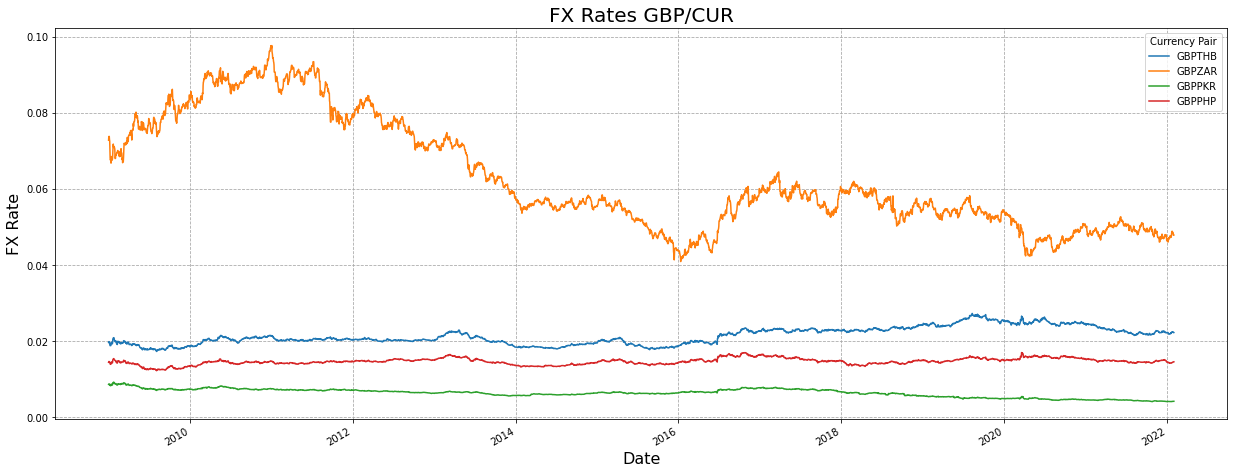

In [14]:
gbpcur.plot()
plt.title('FX Rates GBP/CUR', fontsize=20)
plt.legend().set_title('Currency Pair')
plt.xlabel('Date', fontsize=16)
plt.ylabel('FX Rate', fontsize=16)
plt.grid(color='darkgray', linestyle='dashed')

**2-2-3. Run carry trade simulation**

In [15]:
php_trade = simCarryTrade(lend_cur='PHL',fx_lend_cur='PHP')
php_trade

Trade  | data  | Retrieved all rates data from Quandl.
Trade  | data  | Data has date range from 2014-12-03 00:00:00 to 2022-01-31 00:00:00.


,5.0,GBR_5y,USDPHP,USDGBP,GBPPHP,position
Date,,,,,,
2014-12-03,7.8490,1.3597,44.6972,0.6378,0.0143,1
2014-12-10,7.8478,1.3014,44.5913,0.6363,0.0143,1
2014-12-17,7.8462,1.1773,44.7633,0.6421,0.0143,1
2014-12-24,7.8445,1.2785,44.6733,0.6429,0.0144,1
2014-12-31,7.8445,1.1641,44.7704,0.6419,0.0143,1
...,...,...,...,...,...,...
2021-12-29,7.8177,0.7818,51.0085,0.7446,0.0146,1
2022-01-05,7.8146,0.8639,51.0675,0.7392,0.0145,1
2022-01-12,7.8181,0.9440,51.2005,0.7331,0.0143,1


In [16]:
thb_trade = simCarryTrade(lend_cur='THA',fx_lend_cur='THB')
thb_trade

Trade  | data  | Retrieved all rates data from Quandl.
Trade  | data  | Data has date range from 2014-12-03 00:00:00 to 2022-01-31 00:00:00.


,5.0,GBR_5y,USDTHB,USDGBP,GBPTHB,position
Date,,,,,,
2014-12-03,2.3085,1.3597,32.8566,0.6378,0.0194,1
2014-12-10,2.3072,1.3014,32.8296,0.6363,0.0194,1
2014-12-17,2.3033,1.1773,32.9540,0.6421,0.0195,1
2014-12-24,2.3033,1.2785,32.8855,0.6429,0.0195,1
2014-12-31,2.3033,1.1641,32.8991,0.6419,0.0195,1
...,...,...,...,...,...,...
2021-12-29,2.3602,0.7818,33.5484,0.7446,0.0222,1
2022-01-05,2.3563,0.8639,33.1845,0.7392,0.0223,1
2022-01-12,2.3525,0.9440,33.3705,0.7331,0.0220,1


In [20]:
zar_trade = simCarryTrade(lend_cur='ZAF',fx_lend_cur='ZAR')
zar_trade

Trade  | data  | Retrieved all rates data from Quandl.
Trade  | data  | Data has date range from 2014-09-03 00:00:00 to 2020-11-11 00:00:00.


,5.0,GBR_5y,USDZAR,USDGBP,GBPZAR,position
Date,,,,,,
2014-09-03,NaN,1.7631,10.7258,0.6071,0.0566,0
2014-09-10,9.6520,1.7412,10.8801,0.6209,0.0571,1
2014-09-17,9.6470,1.8072,10.9294,0.6151,0.0563,1
2014-09-24,9.6501,1.8219,11.1600,0.6101,0.0547,1
2014-10-01,9.6514,1.7153,11.2810,0.6167,0.0547,1
...,...,...,...,...,...,...
2020-10-14,9.8555,-0.0443,16.4621,0.7738,0.0470,1
2020-10-21,9.8538,-0.0459,16.4102,0.7699,0.0469,1
2020-10-28,9.8490,-0.0602,16.1934,0.7666,0.0473,1


In [21]:
pkr_trade = simCarryTrade(lend_cur='PAK',fx_lend_cur='PKR')
pkr_trade

Trade  | data  | Retrieved all rates data from Quandl.
Trade  | data  | Data has date range from 2014-08-13 00:00:00 to 2020-04-01 00:00:00.


,5.0,GBR_5y,USDPKR,USDGBP,GBPPKR,position
Date,,,,,,
2014-08-13,13.0662,1.8062,99.0067,0.5949,0.0060,1
2014-08-20,13.0662,1.7991,100.2939,0.6017,0.0060,1
2014-08-27,13.0663,1.6721,101.7882,0.6045,0.0059,1
2014-09-03,13.0667,1.7631,102.1748,0.6071,0.0059,1
2014-09-10,13.0659,1.7412,101.8767,0.6209,0.0061,1
...,...,...,...,...,...,...
2020-03-04,13.0741,0.2017,153.4673,0.7805,0.0051,1
2020-03-11,13.0741,0.1624,158.1972,0.7733,0.0049,1
2020-03-18,13.0741,0.5187,159.4818,0.8264,0.0052,1
